# Ground motion simulation with Kinematic source model
## Generate adaptively-refined mesh informed by 3D velocity model (Wellington Basin)
#### Created By S. Yuan
#### Modified by D. Li (d.li@gns.cri.nz)
#### 22 Nov. 2023
#### NSHM-SRM

## Step 1. prepare 3D velocity model

In [2]:
# load modules
import matplotlib.pyplot as plt
import numpy as np
import gmsh
from scipy import signal
import numpy as np
from netCDF4 import Dataset

# from scipy.interpolate import interp1d
import pandas as pd


## 1.3 create Netcdf SeisSol input

In [3]:
# if 3d basin structure (rho, mu, lambda)

def write_netcdf_inp(fname,Nx, Nz, grdvel, grdrho,vpvs):
    
    # vp_orig, z_orig, rho_orig is from national wide 1d model
    # vp_1d = np.interp(grdz,z1d,vp1d)
    # rho_1d = np.interp(grdz,z1d,vp1d)

    nu = 0.25
    # print(lam_1d,rho_1d)
    
# or using nu and shear modulus
# lamb = G *  2 * nu * (1-2*nu)

# # shear modulus
# G = E / (1 + nu) / 2.

# vp_model = np.sqrt( (lamb + 2* G)/rho_model)
# vs_model = np.sqrt(G/rho_model)
    
    # in case uniform 
    vp = 2600.32
    rho = 1900.0

    ### output for ASAGI format
    fout = Dataset(fname,'w',format='NETCDF4')
    # fview = Dataset('matBasin_mu_3d_view.nc','w+',format='NETCDF4')

    fout.createDimension('x',Nx)
    fout.createDimension('y',Nx)
    fout.createDimension('z',Nz)
    fout.createVariable('x','f8',('x',))
    fout.createVariable('y','f8',('y',))
    fout.createVariable('z','f8',('z',))
    fout.variables['x'][:] = np.unique(grdx);
    fout.variables['y'][:] = np.unique(grdy);
    fout.variables['z'][:] = np.unique(grdz);
    
    material = np.dtype([('rho',np.float32),('mu',np.float32),('lambda',np.float32)])
    data = fout.createCompoundType(material,'material')
    vv = fout.createVariable('data',data,dimensions=('z','y','x'))
    # vv = fout.createVariable('mu','float64', ('z','y','x')) # note: unlimited dimension is leftmost

    for i in np.arange(Nx):
        for j in np.arange(Nx):
            rho_1d = grdrho[:,j,i]
            mu_1d = grdvel[:,j,i] **2 * rho_1d # convert to 1d mu profile
            # lam_1d = 2 * mu_1d * nu * (1 - 2*nu) 
            vp = vpvs * grdvel[:,j,i]
            lam_1d = vp**2 * rho_1d - 2 * mu_1d  # using vpvs ratio
            # print(mu_1d.shape, lam_1d.shape)
            for k in range(Nz):
                vv[k,j,i] = (rho_1d[k], mu_1d[k],lam_1d[k])# 3D velocity model
    
    fout.close()

## 1.2. 1D velocity profile from National wide model

In [12]:
import pyproj

# convert  # UTM projection
lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
myproj = pyproj.Proj(init='epsg:2193', datum='WGS84')
    

/Users/duoli/anaconda3/envs/py39/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [11]:
### laod velocity model from https://zenodo.org/records/3779523

vfile = open('../Velocity/vlnzw2p2dnxyzltln.tbl.txt','r')
vdata = np.loadtxt(vfile,skiprows=2)
print(vdata.shape)

zgrids = np.array([ -15. ,  -1.  , 1.  ,  3.,    5.,    8. ,  15.  , 23. ,  30. ,  34.,   38.,   42.,   48. ,  55.,  65. ,  85.,  105.,
                   130. , 155. , 185.,225. , 275.,  370. , 620.,  750.])

print(xgrids.size,ygrids.size,zgrids.size)

# reshape into matrix with index of [z,y,x]
vp_matx = np.reshape(vdata[:,0],[25,70,64])
vs_matx = np.reshape(vdata[:,2],[25,70,64])
rho_matx = np.reshape(vdata[:,3],[25,70,64])

# Coordinates
lon_matx = np.reshape(vdata[:,10],[25,70,64])
lat_matx = np.reshape(vdata[:,9],[25,70,64])

# get long and lat grids in each dimension
lon = lon_matx[1,1,:]
lat = lat_matx[1,:,1]

print(lon.shape,lat.shape)
      
print(lon[25],lat[43])
print(vs_matx[:,25,43])


(112000, 11)
64 70 25
(64,) (70,)
178.2337 -39.0932
[1.93 2.51 2.76 2.84 3.04 3.4  3.74 3.92 3.99 4.42 4.81 5.07 5.1  5.19
 5.05 4.81 4.8  4.82 4.79 4.84 4.92 4.98 5.16 5.9  6.13]


(2, 38487)


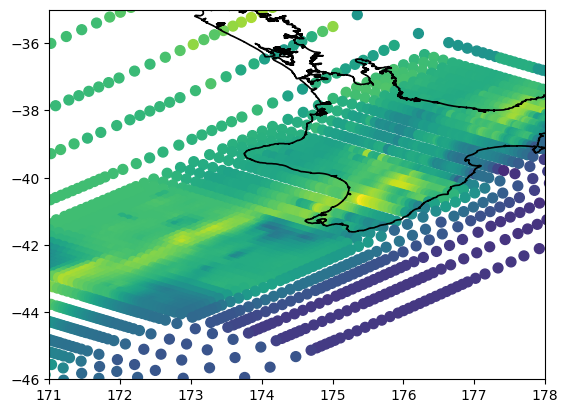

In [17]:
# Find Wellington city
coastfile ='../Geometry/CoastNorth.txt.npy'
coast =  np.load(coastfile)
print(coast.shape)

# selected velocity range
plt.figure()
plt.scatter(lon_matx[1,:,:],lat_matx[1,:,:],s = 50, c = vs_matx[1,:,:])

plt.plot(coast[0,:],coast[1,:],'-k',linewidth=1.2)

plt.xlim(171,178) 
plt.ylim(-46,-35)

plt.savefig('3Dvel_NZd0.png',dpi=300)
plt.show()


In [ ]:
# Write 3D velocity model for Wellington Basin

# if 1D used
# rho_d  = rho_uni
# mu_d   = rho_d * vs_uni **2
# lamb_d = rho_d * vp_uni**2 - 2.0 * mu_d

# nx_d = 5
# ny_d = 5
# nz_d = np.shape(rho_d)[0]

# # extend the range wide to save the interpolate

# x_d=np.linspace(xmin-10e3,xmax+10e3,nx_d) 
# y_d=np.linspace(ymin-10e3,ymax+10e3,ny_d)
# z_d=z 
# z_d[-1] = 10e3


# ### output for ASAGI format
# fout = Dataset('matBasin_rho_mu_lam_3d.nc','w',format='NETCDF4')
# # fout = Dataset('matBasin_rho_mu_lam_1d.nc','w',format='NETCDF4')

# fout.createDimension('x',nx_d)
# fout.createDimension('y',ny_d)
# fout.createDimension('z',nz_d)
# fout.createVariable('x','f4',('x',))
# fout.createVariable('y','f4',('y',))
# fout.createVariable('z','f4',('z',))
# fout.variables['x'][:] = x_d;
# fout.variables['y'][:] = y_d;
# fout.variables['z'][:] = z_d;

# # material = np.dtype([('rho',np.float32),('lambda',np.float32)])
# material = np.dtype([('rho',np.float32),('mu',np.float32),('lambda',np.float32)])
# data = fout.createCompoundType(material,'material')
# vv = fout.createVariable('data',data,dimensions=('z','y','x'))

# for j in range(ny_d):
#     for i in range(nx_d):
#         for k in range(nz_d):
#             vv[k,j,i] = (rho_d[k],mu_d[k], lamb_d[k]) # 3D velocity model
#         # vv[:,j,i] = (mu_d,lamb_d) # 3D velocity model


# fout.close()

In [80]:
# if 3D used

# select 3D
xgrid_3d = xgrids[15:55]
ygrid_3d = ygrids[25:50]

vs_3d = vs_matx[:,25:50,15:55]*1000
vp_3d = vp_matx[:,25:50,15:55]*1000
rho_3d = rho_matx[:,25:50,15:55]*1000


### output for ASAGI format
fout = Dataset('newVel/matBasin_rho_mu_lam_3d_cor2.nc','w',format='NETCDF4')
# fout = Dataset('matBasin_rho_mu_lam_1d.nc','w',format='NETCDF4')

nx_d = len(xgrid_3d)
ny_d = len(ygrid_3d)
nz_d = np.shape(z)[0]

# extend the range wide to save the interpolate

fout.createDimension('x',nx_d)
fout.createDimension('y',ny_d)
fout.createDimension('z',nz_d)
fout.createVariable('x','f4',('x',))
fout.createVariable('y','f4',('y',))
fout.createVariable('z','f4',('z',))
fout.variables['x'][:] = xgrid_3d*1e3;
fout.variables['y'][:] = ygrid_3d*1e3;
fout.variables['z'][:] = z;

# material = np.dtype([('rho',np.float32),('lambda',np.float32)])
material = np.dtype([('rho',np.float32),('mu',np.float32),('lambda',np.float32)])
data = fout.createCompoundType(material,'material')

vv = fout.createVariable('data',data,dimensions=('z','y','x'))

for j in range(ny_d):
    for i in range(nx_d):
                
        rho_d  = rho_3d[:,j,i]
        mu_d   = rho_3d[:,j,i] * vs_3d[:,j,i] **2
        lamb_d = rho_3d[:,j,i] * vp_3d[:,j,i]**2 - 2.0 * mu_d
        
        rho_inte = np.interp(z,z_orig[::-1],rho_d[::-1])
        mu_inte =  np.interp(z,z_orig[::-1],mu_d[::-1])
        lamb_inte = np.interp(z,z_orig[::-1],lamb_d[::-1])
        
        for k in range(nz_d):
            vv[k,j,i] = (rho_inte[k],mu_inte[k], lamb_inte[k]) # 3D velocity model
        # vv[:,j,i] = (mu_d,lamb_d) # 3D velocity model


fout.close()

In [75]:
# fig,ax=plt.subplots(1,1,figsize=(5,5))
# ax.plot(vs,z,'-k',label='Vs');
# ax.plot(vp,z,'-r',label='Vp');
# plt.legend()
# plt.savefig('1D_vel.png',dpi=150,transparent=False)
theta = 140
print(np.cos(140/180*np.pi), np.sin(140/180*np.pi))
print(-np.sin(140/180*np.pi),np.cos(140/180*np.pi))

print(x1,y1)

-0.7660444431189779 0.6427876096865395
-0.6427876096865395 -0.7660444431189779
1600000.0 5350223.775180822


## Step 2. create mesh file with topography

In [16]:
# This is an example to load Topographic date from Etopo
# load netcdf reader.

from netCDF4 import Dataset
import pyproj


def load_topo_data(ncfile):
    nc = Dataset(ncfile,'r')
    lon= nc.variables['lon'][:]
    lat = nc.variables['lat'][:]
    topo = nc.variables['z'][:,:]
    lons,lats=np.meshgrid(lon,lat)

    samples = len(lon)
    
    min_latitude= lat.min()
    min_longitude= lon.min()
    
    max_latitude= lat.max()
    max_longitude= lon.max()
    
    mark_x = np.where( topo == -32768 )[0]
    mark_y = np.where( topo == -32768 )[1]
    # for x, y in zip(mark_x, mark_y) :
    #     slice = topo[max(0, x-1):x+1, max(0,y-1):y+1] # assuming a 5x5 square
    #     topo[x,y] = np.mean([i for i in slice.flatten() if i > 0])  # threshold is 0
    
    x_lon = np.linspace((min_longitude),(max_longitude),samples)
    y_lat = np.linspace((min_latitude),(max_latitude),samples)
    
    # UTM projection
    lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
    # myproj = pyproj.Proj(proj='tmerc',lon_0=168, datum='WGS84')
    # myproj = pyproj.Proj(proj='utm',zone='59', datum='WGS84') # nzmg  
    myproj = pyproj.Proj(init='epsg:2193', datum='WGS84')
    
    xyz_map = pyproj.transform(lla, myproj, x_lon,y_lat,np.zeros(len(x_lon)), radians=False)
    x = xyz_map[0]
    y = xyz_map[1]
    # print(x,y)
    
    # Wellington city Epicenter coordinate
    lat_sou = -41.3
    lon_sou = 174.75 
    xyz_sou = pyproj.transform(lla, myproj, lon_sou,lat_sou, radians=False) # Epicenter in UTM domain
    print(xyz_sou)
    
    xmin = x[0] # Unit (m)
    xmax = x[-1]
    
    ymin = y[0]
    ymax = y[-1]

    return topo, x, y

## Plot topographsic area

In [42]:
# Plot topo data and check if the data is well-resolved

from matplotlib.colors import LightSource

# ls = LightSource(azdeg=35, altdeg=45)
# cmap = plt.cm.terrain


fig, ax = plt.subplots(1,1,figsize=(10,8))

# Lat/Lon 
# im1 = ax.imshow(topo, interpolation='bilinear', cmap='terrain',aspect='auto',
#                    origin='lower', extent=[x_lon[0], x_lon[-1], y_lat[0], y_lat[-1]+1],
#                    vmax=700, vmin=-1000)
# ax[0].set_title('Lon/Lat',fontsize=14)
# ax[0].set_xlabel('Longitude ($^{\circ}$)', fontsize=12)
# ax[0].set_ylabel('Latitude ($^{\circ}$)', fontsize=12)
# # ax[0].scatter(lon_sou,lat_sou, s=100, marker='.', c='r',label='WEL')
# ax[0].legend(loc=1,prop={"size":12})2

# UTM domain
im2 = ax.imshow(topo, interpolation='bilinear', cmap='terrain',aspect='auto',
                   origin='lower', extent=[xrange[0], xrange[-1], yrange[0], yrange[-1]+1],
                    vmax=700, vmin=-700)

# blend_mode = ['hsv','overlay', 'soft']

# rgb = ls.shade(topo, cmap=cmap, blend_mode='overlay', vert_exag=2, dx=23, dy=30 )
# im2 = ax.imshow(rgb, cmap=cmap,origin='lower',aspect='auto',extent=[x[0], x[-1], y[0], y[-1]+1],vmax=600, vmin=-1000)

ax.scatter(x_site,y_site, s=20, marker='^', c='b')

for k in range(subtable.sta.size):
    ax.text(x_site[k]-100.0,y_site[k]+100.0,s=subtable.sta[k],fontsize=5)

ax.xaxis.major.formatter.set_powerlimits((-2,1))
ax.yaxis.major.formatter.set_powerlimits((-2,1))

ax.set_xlabel('X (m)', fontsize=12)
ax.set_ylabel('Y (m)', fontsize=12)
ax.set_title('NZTM2000 projection',fontsize=14)
ax.legend(loc=1,prop={"size":12})
ax.set_aspect(1)
ax.set_xticklabels([])
ax.set_yticklabels([])

fig.colorbar(im2,ax=ax,label='Elevation (m)', fraction=0.046, pad=0.025, extend='both')

outname = 'TopoWel'+'-basin3.png'
plt.savefig(outname, dpi=300, transparent=False)
plt.close()

<IPython.core.display.Javascript object>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [ ]:
print(subtable.sta,subtable.Vs30)

## Step 3. create Velocity model (NetCDF) file for SeisSol input
### Notes: original data from Matt Hill (GNS); series; interpolate to structured grids with designed spatial resolution (Nx, Ny, Nz).


In [169]:
# z_d[-1] = 10e3
# # 
# print(z_d)

<IPython.core.display.Javascript object>

### step 3.1. generate 3D velocity model


## 4. Generate Input kinematic source from SRF
### this is an example using SRF format source

In [ ]:
# define the function from ~/SeisSol/SeisSol/preprocessing/science/kinematic_models/generate_FL33_input_files.py
# to read fault from srf and write a new one
# import Class FaultPlane based on module from https://github.com/SeisSol/Examples/blob/master/Northridge/generating_the_nrf.sh

from FaultPlaneWrite import FaultPlane

filename  = '/Users/duoli/Documents/SeisSol/Training/northridge/northridge_resampled.srf'
filename = '/Users/duoli/Documents/NSHM_SRM/Model_kinematic/northridge.srf'
outfile = 'northridge_format.srf'

p1 = FaultPlane()
p1.init_from_srf(filename)
p1.write_srf(outfile)


In [ ]:
## load source using SRF format

# print(p1.lon,p1.lat)

# origin of the source
lat_sou = -41.3
lon_sou = 174.75 

min_lat = -41.4
max_lat = -41.197
max_lon = 174.903 
min_lon = 174.7

# convert the source geometry to fit the domain area 
p1.lon = (p1.lon- p1.lon.min() )/(p1.lon.max()-p1.lon.min()) *  (max_lon-min_lon)/10 + lon_sou
p1.lat = (p1.lat -p1.lat.min()) /(p1.lat.max()-p1.lat.min()) *  (max_lat-min_lat)/10 + lat_sou
p1.depth = p1.depth-p1.depth + 2.0

print(p1.lon.shape,p1.lat.shape)

p1.write_srf(outfile)


In [238]:
# shfit to the current origin city of e.g. Wellingtone

# plot a figure showing the source 

fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.imshow(topo, interpolation='bilinear', cmap='terrain',aspect='auto',
                   origin='lower', extent=[min_lon,max_lon,min_lat,max_lat],
                   vmax=700, vmin=-1000)

ax.contour(p1.lon,p1.lat,p1.slip1,cmap='viridis') # kinatic source

fig.colorbar(im2,ax=ax,label='Elevation (m)', fraction=0.046, pad=0.025, extend='both')
outname = 'TopoWel'+'-source.png'
plt.savefig(outname,dpi=150,transparent=False)
plt.show()

<IPython.core.display.Javascript object>

In [65]:
# print(p1.lon,p1.lat)
nc = Dataset(ncfile,'r')
lon= nc.variables['lon'][:]
lat = nc.variables['lat'][:]
topo = nc.variables['z'][:,:]

### 4.1 POint source

In [42]:
## plot source and receivers, as well as basin structure

# filecsv = '/Users/duoli/Documents/NSHM_SRM/Model_kinematic/cat_subtable_redat_reupdated.csv'
# cat_subtable= pd.read_csv(filecsv)
# print(cat_subtable["Slip_cm"])

filecsv= '/Users/duoli/Documents/NSHM_SRM/Model_kinematic/cat_subtable.csv'
cat_subtable= pd.read_csv(filecsv)

import seaborn as sbn
# import matplotlib
# matplotlib.style.use('seaborn-v0_8-talk') # Lovely plotting style

point1 = np.array([ 174.75, -41.3  ])
point1 = np.array([174.7223, -41.4383])
point2 = np.array([175.0763, -41.0652])

mypoint1 = pyproj.transform(lla,myproj, point2[0],point2[1])

# catalog
mypoint2 = pyproj.transform(lla,myproj,cat_subtable["Longitude"],cat_subtable["Latitude"])

# coastline
mypoint3= pyproj.transform(lla,myproj,coast[0,:],coast[1,:])

fig, ax = plt.subplots(1,1,figsize=(6,6))
# ax.imshow(topo, interpolation='bilinear', cmap='gray',aspect='auto',
#                    origin='lower', extent=[xrange[0],xrange[-1],yrange[0],yrange[-1]],
#                    alpha=1.0,vmax=1000,vmin=-1000)
# ax.imshow(topo, interpolation='bilinear', cmap='gray',aspect='auto',
#                    origin='lower', extent=[lon.min(),lon.max(),lat.min(),lat.max()],
#                    alpha=1.0,vmax=1000,vmin=-1000)
# data from load_vel_csv()
# im = ax.imshow(grdvel[75,:,:], interpolation='bilinear', cmap='magma',aspect='auto',
#                    origin='lower', extent=[grdx[0],grdx[-1],grdy[0],grdy[-1]],alpha=0.3,
#                    vmax=160, vmin= 700)

sbn.scatterplot(data=cat_subtable,x="Longitude",y="Latitude",marker="*",hue="CD",ax=ax,legend=False,palette='deep')
ax.plot(coast[0,:],coast[1,:],'-',color='black',linewidth=1.2)
# sbn.scatterplot(data=siteTable,x="lon",y="lat",hue="Vs30",size=1,ax=ax,legend=False,palette='plasma_r')
ax.plot(point2[0],point2[1],'*',c='tomato',markersize=12)

# ## basin edge stations
# # ax.plot(siteBasinEdge[::3,0],siteBasinEdge[::3,1],'^',color='royalblue',markersize=5.0)
# # stations
# ax.scatter(x_site,y_site, s=23, marker='^', c='royalblue')

ax.set(ylim=(-41.8,-40.9),xlim=(174.3,175.3))

# fig.colorbar(cb1,ax=ax,label='vs', fraction=0.046, pad=0.025, extend='both')

outname = 'TopoWel'+'-point2024.png'

plt.savefig(outname, dpi=300,transparent=False)
plt.show()

/var/folders/w1/_6wbwxqn58j2p6t9v4n73wcr0000gn/T/ipykernel_47866/799745830.py:18: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  mypoint1 = pyproj.transform(lla,myproj, point2[0],point2[1])
/var/folders/w1/_6wbwxqn58j2p6t9v4n73wcr0000gn/T/ipykernel_47866/799745830.py:21: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  mypoint2 = pyproj.transform(lla,myproj,cat_subtable["Longitude"],cat_subtable["Latitude"])
/var/folders/w1/_6wbwxqn58j2p6t9v4n73wcr0000gn/T/ipykernel_47866/799745830.py:24: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  mypoint3= pyproj.transform(lla,myproj,coast[0,:],coast[1,:])


<IPython.core.display.Javascript object>

In [43]:
# print（vs_3d[1]
# fig,ax=plt.subplots(1,1)
# ax.imshow(vs_3d[1,:,:],origin='lower', extent=[qx.min()*1e3+x1,qx.max()*1e3*x1,qy.min()*1e3+y1,qy.max()*1e3+y1])
# plt.savefig('test.png')
# plt.show()
print(mypoint1)


(1774453.1244413909, 5451928.112861949)


In [27]:
# print(grdvel[75,:,:].min()) # check depth profile that show sh

coastfile ='../Geometry/CoastNorth.txt.npy'
coast =  np.load(coastfile)
print(coast.shape)

(2, 38487)


In [180]:
# load catalog data downloade from GeoNet

catfile = '/Users/duoli/Documents/NSHM_SRM/Model_kinematic/cat_subtable.csv'
# catfile = '/Users/duoli/Documents/NSHM_SRM/Model_kinematic/geonet_cat.csv'

cat_subtable = pd.read_csv(catfile)
print(cat_subtable.keys(),cat_subtable['Mw'])
# select earthquake in the research area
# exd = 0.1
# min_lat = -41.4-exd
# max_lat = -41.197 + exd

# max_lon = 174.903 +exd
# min_lon = 174.7-exd

# table1_select = table1[(table1['Longitude']>min_lon )& (table1['Longitude']<max_lon) & (table1['Latitude']>min_lat )& (table1['Latitude']<max_lat)]

# siteTable = pd.DataFrame(table1_select)
# siteTable.to_csv('cat_subtable.csv')
# print(table1_select.shape, print(siteTable.keys()))


Index(['Unnamed: 0', 'PublicID', 'Date', 'Latitude', 'Longitude', 'strike1',
       'dip1', 'rake1', 'strike2', 'dip2', 'rake2', 'ML', 'Mw', 'Mo', 'CD',
       'NS', 'DC', 'Mxx', 'Mxy', 'Mxz', 'Myy', 'Myz', 'Mzz', 'VR', 'Tva',
       'Tpl', 'Taz', 'Nva', 'Npl', 'Naz', 'Pva', 'Ppl', 'Paz', 'Method'],
      dtype='object') 0    4.7
1    4.3
2    3.8
3    4.0
4    4.3
5    3.9
6    4.0
7    3.5
8    3.4
Name: Mw, dtype: float64


## 5. Receivers around the Basin edge


In [ ]:
# how to prepare basin